# Project 3: Reddit NLP - Multinomial Naive Bayes

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# I really like this color, so it will be used for everything
DO = '#7D1B7E'

%matplotlib inline
plt.style.use('fivethirtyeight')

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


I am now going to attempt to classify the subreddit posts by utilizing a count vectorizer along with a multinomial naive bayes model. With the model, I will be able to estimate the probability that a submission is posted in a specific class, and then classify the submission.

Loading dataframe, stop words, train/test splits.

In [2]:
with open('../assets/df.pkl','rb') as f:
    df = pickle.load(f)
with open('../assets/stop_words_updated.pkl', 'rb') as f:
    stop_words = pickle.load(f)
with open('../assets/X_train.pkl', 'rb') as f: 
    X_train = pickle.load(f)
with open('../assets/X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)
with open('../assets/y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)
with open('../assets/y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)

In [3]:
df.head()

selftext            subreddit  \
0  The beginning   We have been in a monogamous r...  relationship_advice   
1  We have been together   months  It was a norma...  relationship_advice   
2  Im a    year old college student  never been o...               dating   
3  Gf and I both     been dating for   months and...  relationship_advice   
4  Ok  some background  Bf and I have been togeth...  relationship_advice   

   dating                                              token  word_count  \
0       0  [beginning, we, monogamous, relationship, year...        1019   
1       0  [we, together, months, normal, night, she, got...          97   
2       1  [im, year, old, college, student, never, date,...          51   
3       0  [gf, i, dating, months, weve, pretty, good, re...         193   
4       0  [ok, background, bf, i, together, years, short...         168   

   char_count                                        clean_token  
0        8921  beginning we monogamous relationship year shy ...  
1         777  we together months normal night she got shower...  
2         461  im year old college student never date done an...  
3        1797  gf i dating months weve pretty good relationsh...  
4        1360  ok background bf i together years shortly we f...

## TF-IDF

$$
\mathrm{tfidf}(t,d,D) = \frac{N_\text{term}}{N_\text{terms in Document}} \cdot \log\frac{N_\text{Documents}}{N_\text{Documents that contain term}}
$$

Instead of using a CountVectorizer to convert the documents (submissions) into numbers, I am going to use the term frequency–inverse document frequency. The level of feature importance of gender pronouns, such as 'he', 'his', 'she', 'her', accross the corpus should not be inflated simply due to the fact that they appear more often than other words.

The TF-IDF consists of two parts, the Term Frequency and the Inverse Document Frequency, that provides a weight of how important a particular word is accross the corpus, which is the whole collection of documents.

Term Frequency
- The frequency of how often a word appears in a document

Inverse Document Frequency
- Determines whether a word is rare or common, which helps to adjust that some words appear more frequently than others in general. It measures how much information a word carries.

Combining the two together, the TF-IDF value increases proportionally to the term frequency and is offset by the number of documents in the corpus that contain the word.

## Multinomial Naive Bayes

Though the multinomial Naive Bayes classifier is suited to work with discrete features, such as the word count, the model can be used with TF-IDF's fraction values. Once the text is vectorized by TF-IDF, the TF-IDF returns the most important features, which are words.

The dating subreddit is labeled as the positive class and the relationship advice subreddit is labeled as the negative class. 

Given the TF-IDF selected features occuring in a given post, we are calculating two probabilities: the probability that the post is positive and the probability that the post is negative. The larger of the two probabilities ultimately determines whether the post belongs to the positive or negative class. 

With the naive bayes model, we are making two assumptions that might be counter-intuitive because words are dependent on each other to create meaningful sentences:
1. The model assumes that the features (words) are independent of one another to simplify the conditional probability that arises from Bayes' Theorem. 
2. The bag of words obtained from the vectorizer is unordered.

With the assumptions, we can multiply the likelihood of a class by individual features instead of whole texts. For each selected feature occurence, we are counting how many times the feature appears in the post divided by the total number of words across a class' corpus. 

I am going to examine the model's predictive powers based on individual words.

In [17]:
pipe = Pipeline([
                ('tf', TfidfVectorizer(stop_words = stop_words)),
                ('nb', MultinomialNB())
])

In [18]:
parameters = {
                'tf__max_features' : [500,1000,1500,2000, 5000],
                'tf__ngram_range' : [(1,1), (1,2), (2,2)]
}

In [19]:
gs = GridSearchCV(pipe, param_grid = parameters, cv = 5)

In [20]:
gs.fit(X_train, y_train);

In [21]:
gs.best_params_

{'tf__max_features': 5000, 'tf__ngram_range': (1, 2)}

Based on the GridSearchCV, the best parameters that will return the highest accuracy scores are 5000 max features, and an ngram_range of 1 and 2. 

In [22]:
gs_train_accuracy = round(gs.score(X_train, y_train),2)
print(f'Train Accuracy: {gs_train_accuracy}')

Train Accuracy: 0.83


In [23]:
gs_test_accuracy = round(gs.score(X_test, y_test),2)
print(f'Test Accuracy: {gs_test_accuracy}')

Test Accuracy: 0.81


The train accuracy is 83% and the test accuracy is 81%. At a glance, the results are encouraging as the scores are similar, and there is no overfitting, but I will need to explore the proba's to see the likelihood of how a post is classified. 

## Results - Feature Weights

I am now going to explore which words are the most important in determining whether a post is from the dating subreddit or not.

Grabbing the top feature names and storing it as `vocab`.

In [24]:
vocab = gs.best_estimator_.named_steps['tf'].get_feature_names()

Creating a feature weight dataframe, and determining which words are most important.

In [25]:
coef = list(gs.best_estimator_.named_steps['nb'].coef_[0])

In [26]:
feature_df = pd.DataFrame( {'top_words': vocab, 'importance': coef })

In [27]:
feature_df = feature_df.set_index('top_words')
feature_df = feature_df.sort_values('importance',ascending = False)

In [28]:
feature_df.head(5)

importance
top_words            
she         -4.706530
her         -4.806711
me          -4.848835
he          -4.997237
we          -5.116886

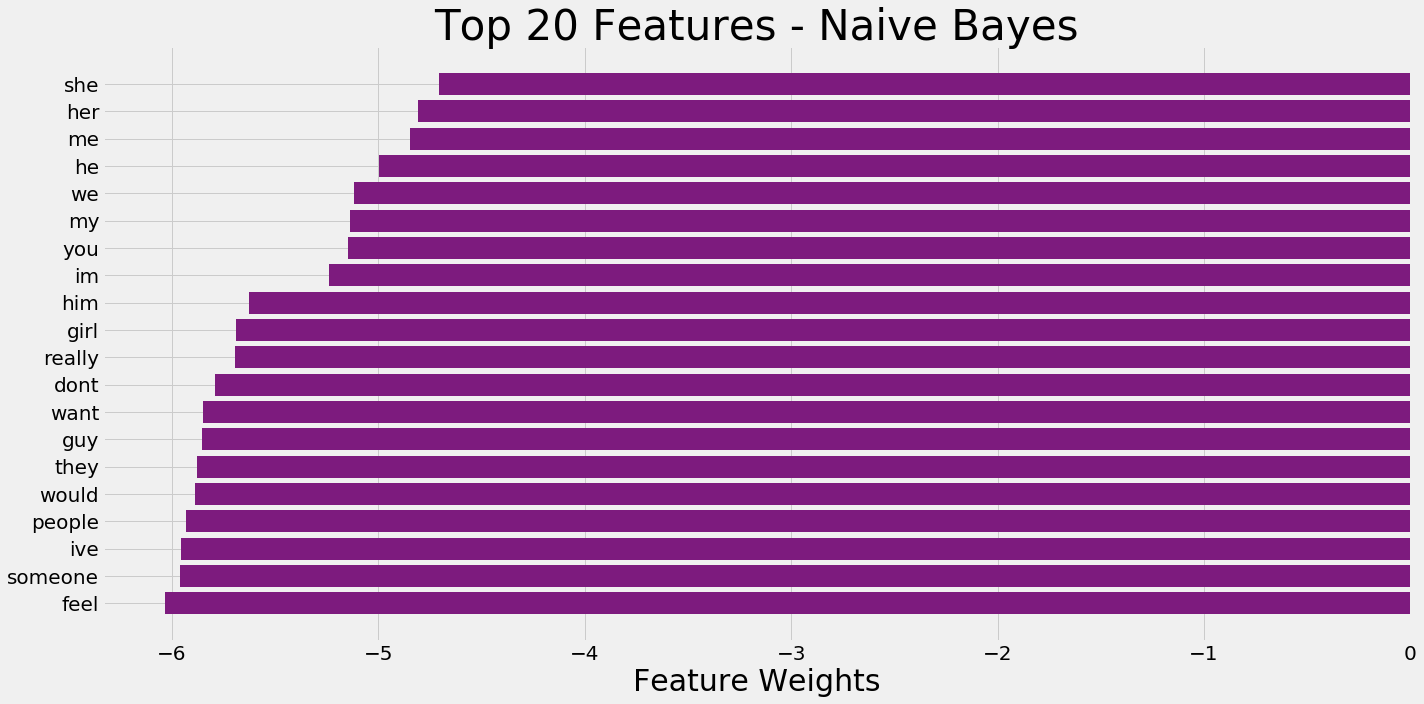

In [29]:
weights = feature_df['importance'].head(20).sort_values()
labels = weights.index

plt.figure(figsize=(20,10))
plt.barh(labels, weights, color = DO)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Feature Weights', fontsize=30)
plt.title(f'Top 20 Features - Naive Bayes', fontsize=42)
plt.tight_layout()

plt.savefig('../plots/top_feature_NB_pres.png')

The barplot above depicts the top 20 features. All of the feature importances are negative which implies that the words better indicate whether the post will be in the negative class, which is the relationship_advice subreddit.

Since there are more words on average in the relationship_advice submissions compared to the dating submissions, the higher occurences of feature words will most likely be in the relationship_advice submissions. 

However, most of the words listed above appear to be common words that do not carry much of a meaning.

## Mean Occurence in Feature Terms

Based on all the negative feature terms, I want to investigate whether the feature terms appear more in the negative class, the relationship_advice subreddit, than the positive class, the dating subreddit.

Obtaining the TF-IDF data:

In [30]:
tf_train_data = gs.best_estimator_.named_steps['tf'].transform(X_train)

Creating a TF-IDF train dataframe using the feature names as vocab.

In [32]:
tf_train_df = pd.SparseDataFrame(tf_train_data, columns=vocab)

Inserting the target train column.

In [33]:
tf_train_df.insert(0, 'target_val', y_train)

Imputing NaN's as 0's.

In [34]:
tf_train_df.fillna(0, inplace=True)

Grouping the subreddit classes, relationship_advice as 0 and dating as 1, and calculating the mean value of the feature names.

In [36]:
grouped_means = tf_train_df.groupby('target_val').mean()

Changing the indices to the classes

In [37]:
grouped_means.index = [0, 1]

In [38]:
grouped_means.T.head()

0         1
ability    0.000423  0.000481
able       0.005117  0.004521
able talk  0.000561  0.000408
abroad     0.000949  0.000548
absolute   0.000679  0.000541

In [39]:
(grouped_means.T[0] > grouped_means.T[1]).mean()

0.5346

In 53.4% of the cases, the mean of the 0 class (relationship_advice) is greater than the mean of the 1 class (dating). The distribution is quite even, so it is a wonder why there is an issue with the negative feature weights. 

## Classification Metrics

The test accuracy score for the gridsearch logistic regression model is 81%. 

I will generate a confusion matrix on our test data because we want to see how our naive bayes classification model performs on unseen data, ie checking whether posts are correctly or incorrectly classified from the dating subreddit.

In [40]:
y_pred = gs.predict(X_test)

In [41]:
cm_def = np.array([['True Negative', 'False Positive'],
                ['False Negative', 'True Positive']])
cm_def = pd.DataFrame(cm_def,columns = ['pred neg', 'pred pos'], index = ['actual neg','actual pos'])

In [42]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, columns = ['pred neg', 'pred pos'], index = ['actual neg','actual pos'])

In [43]:
from IPython.display import display
display(cm_def)
display(cm_df)

pred neg        pred pos
actual neg   True Negative  False Positive
actual pos  False Negative   True Positive

pred neg  pred pos
actual neg      2370       485
actual pos       518      1889

In [44]:
len(X_test)

5262

Out of 5262 unseen dating and relationship_advice subreddit submissions:

**True Positives** - 1889
- Our model correctly predicted that 1889 posts are from the dating subreddit

**True Negatives** - 2370
- Our model correctly predicted that 2370 posts are from the relationship_advice subreddit

**False Positive** - 485
- Our model incorrectly predicted that 576 posts are from the dating subreddit. 

**False Negative** - 418
- Our model incorrectly predicted that 433 posts are from the relationship_advice subreddit

Given that the number of false positives and false negatives are roughly similar and that the true positives and true negatives are similar as well, the model only shows a slight bias towards the majority class which is the relationship_advice subreddit. 

## AUC ROC CURVE

Again, using the AUC ROC curve I will examine how well our model classifies the subreddit posts as 1's and 0's.

In [45]:
pred_proba = gs.predict_proba(X_test)[:,1]

In [46]:
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

Calculating the AUC ROC score.

In [47]:
auc_roc_score = round(roc_auc_score(pred_df['true_values'], pred_df['pred_probs']),2)
auc_roc_score

0.89

The AUC ROC score is 89% which is quite good.

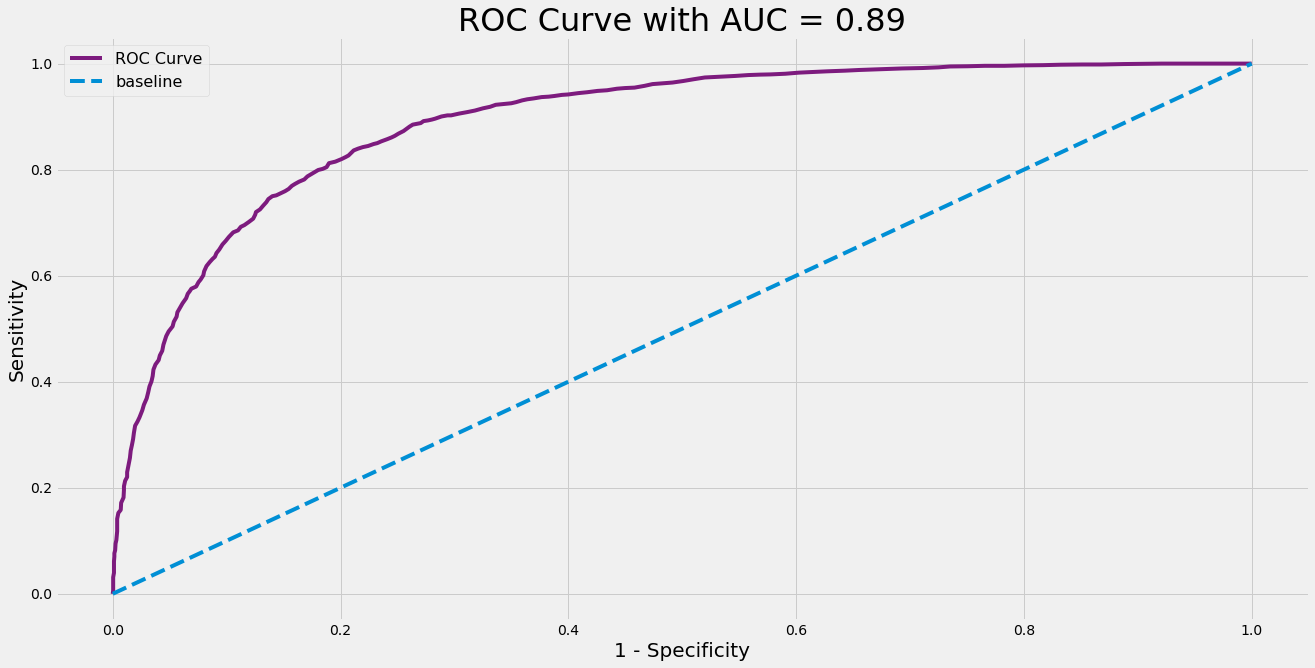

In [48]:
# Create figure.
plt.figure(figsize = (20,10))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    
# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve',
        color = DO)

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {auc_roc_score}', fontsize=32)
plt.ylabel('Sensitivity', fontsize=20)
plt.xlabel('1 - Specificity', fontsize=20)

# Create legend.
plt.legend(fontsize=16);

The blue dashed baseline indicates a perfect overlap between the dating and relationship_advice subreddit.

The ROC curve is generated by varying the classification threshold from 0 to 1. The curve provides a visualization of the tradeoff between sensitivity and specificity.

Through the naive bayes classification model, the subreddit populations are well-separated.

The sensitivity is how many posts did the model get correct out of all dating posts.

In [49]:
sensitivity = round(len(pred_df[(pred_df['true_values'] == 1) & (pred_df['pred_probs'] >= 0.5)])/len(pred_df[pred_df['true_values'] == 1]),2)
sensitivity

0.78

The sensitivity rate is 78%.

The specificity is how many posts did the mdoel get correct out of all the relationship_advice posts.

In [50]:
specificity = round(len(pred_df[(pred_df['true_values'] == 0) & (pred_df['pred_probs'] <= 0.5)])/len(pred_df[pred_df['true_values'] == 0]),2)
specificity

0.83

The specificity rate is 83%.

Despite the great classification metric scores, it appears that the naive bayes model is not a robust model due to its lack of interpretability of its negative feature terms. As a result, the model will not be picked out of the 3 classification models. I will now implement a random forest and examine its accuracy score along with other metrics. 

| Model | Train Accuracy | Test Accuracy | AUC ROC | True Positive | True Negative | False Positive | False Negative |
|---|---|---|---|---|---|---|---|
| Logistic Classification | 87% | 82% | <font color = 'red'> 90% |2015 | 2320 | 535 | 392 |  
| Multinomial Naive Bayes | 83% | <font color = 'red'> 81% | 89% | 1889 | 2370 | 485 | 418 |
| Random Forests | - | - | - | - |- |- |- |

# Proceed to 3C_Modeling: Random Forests